# makeParamSetRunList
Creates pin matrix and sorts data. Also calculates dx matrix for OAT analysis by shifting one param at a time by a given dx value. <br>
__outputRows__ is calculated as $$nSubZones * nPerSubZone$$ 


In [1]:
# Import statements
import makeParamSetHelpers as helper
import numpy as np
import h5py
import sys 
np.set_printoptions(threshold=sys.maxsize)

### Modify and change values here.

In [2]:
# Set these values accordingly to get the desired number of output rows. outputRows = nSubZones * nPerSubZone
nSubZones = 20 
nPerSubZone = 100  

# Set the norm value here. 
norm = 100

# Set the file path for the params csv here.
file_path = './params_reference/params_bbp_calcium.csv'

# Set the value of dx here.
dx = 0.01

# Set params to sample here. Other params will be kept at base value. The default below is to sample all params.
# Passive
# params = [i for i in range(1, 6)] # For mainen
# params = [1, 4, 21, 24] # For bbp
# peeling_step_name = 'passive'

# Potassium
# params = [4, 5, 7, 10]
# params = [5, 7, 12, 13, 17] # For bbp
# peeling_step_name = 'potassium'

# Sodium
# params = [1, 2, 3]
# params = [2, 6, 9, 20] # For bbp
# peeling_step_name = 'sodium'

# Calcium
# params = [6, 8, 9, 11, 12]
params = [10, 11, 15, 18, 19, 23] # For bbp
peeling_step_name = 'calcium'

# Full
# params = [i for i in range(1, 13)] # For mainen
# params = [i for i in range(1, 24)] # For bbp
# peeling_step_name = 'full'

# Set a seed value here for generating the samples between -4 and 4.
seed = 1846353

# Sample pdx to keep the size not too large. The list must be indicies of pin.
# For Full set
# pin_sample_ind = list(range(0, 1000, 5)) # For mainen
# pin_sample_ind = list(range(0, 2000, 10)) # For bbp

# For rest
# pin_sample_ind = list(range(1000)) 
# pin_sample_ind = list(range(0, 10000, 50)) # For GBR
pin_sample_ind = list(range(0, 2000, 5)) # For bbp

First, parse the csv file using *parse_csv*. Then, use *calculate_pmatx* to find the new pin matrix and also calculate **pSortedSetsN** for the OAT analysis. Call *shift_by_dx* on **pSortedSetsN** to get the new augmented dx matrix.<br>
Change the output file names accordingly.

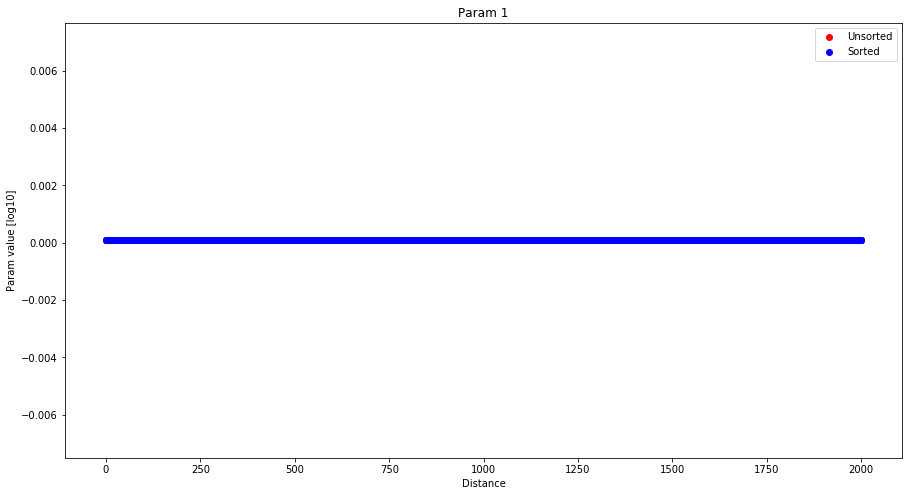

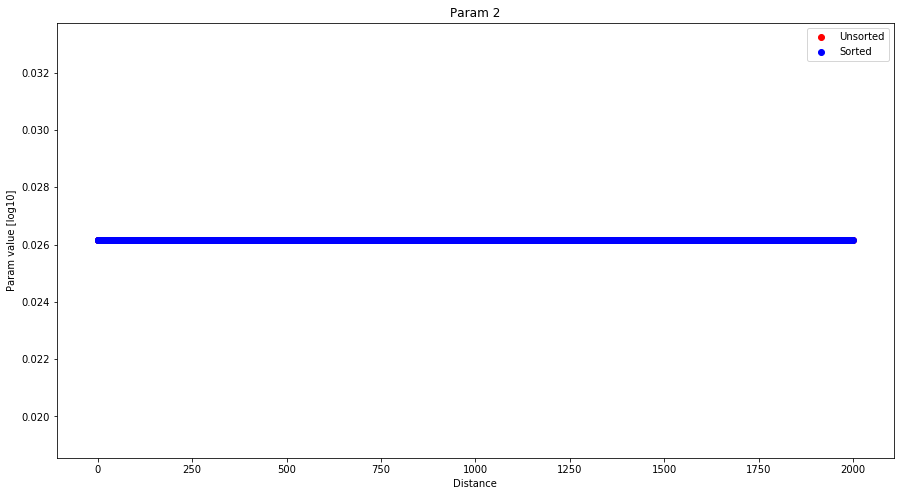

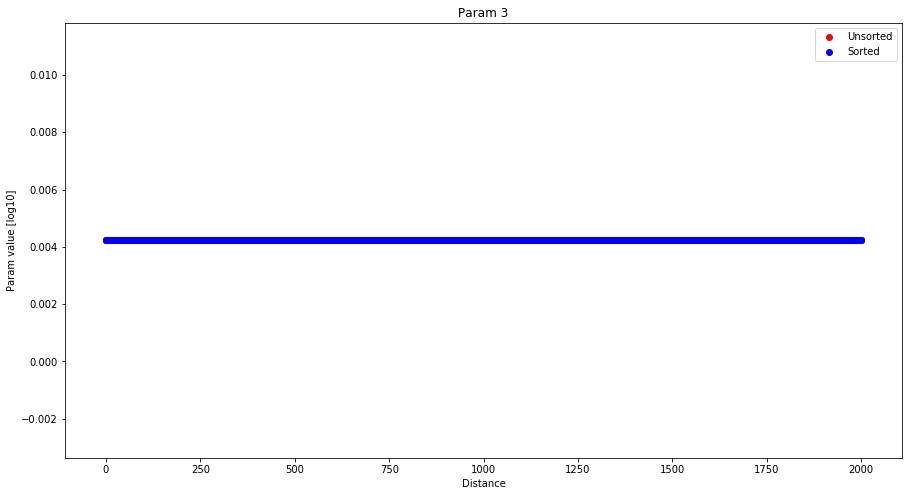

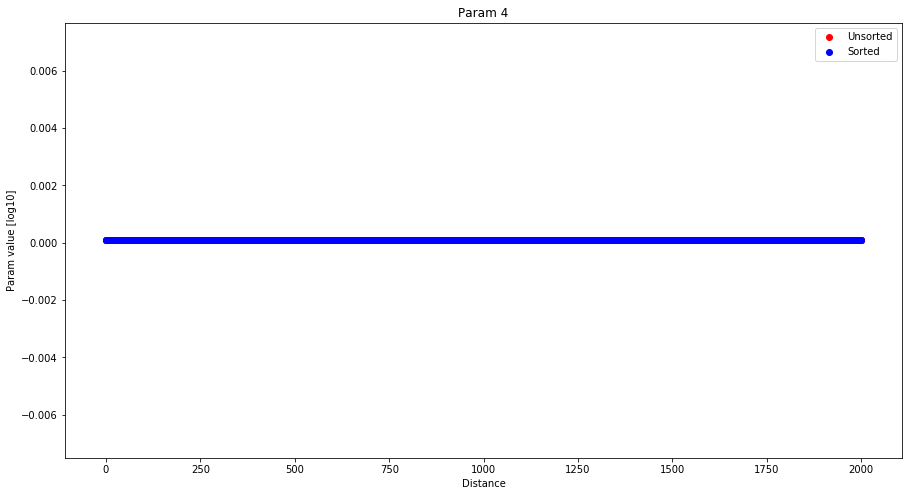

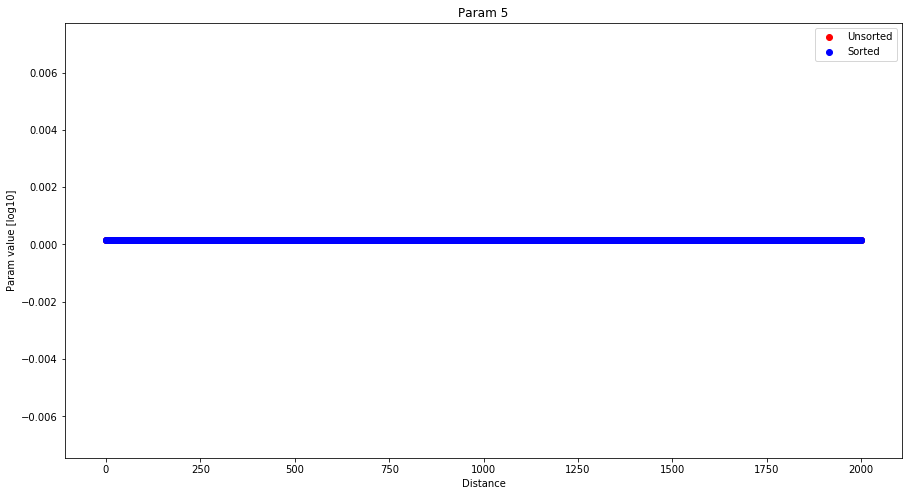

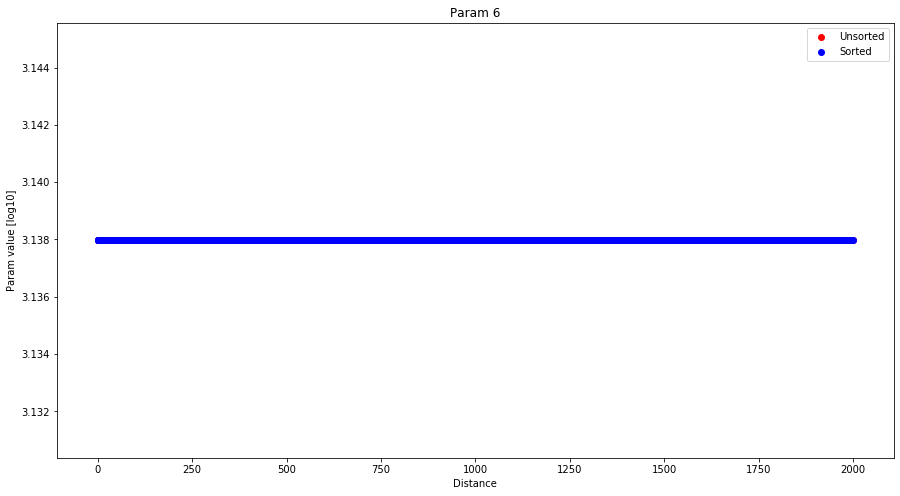

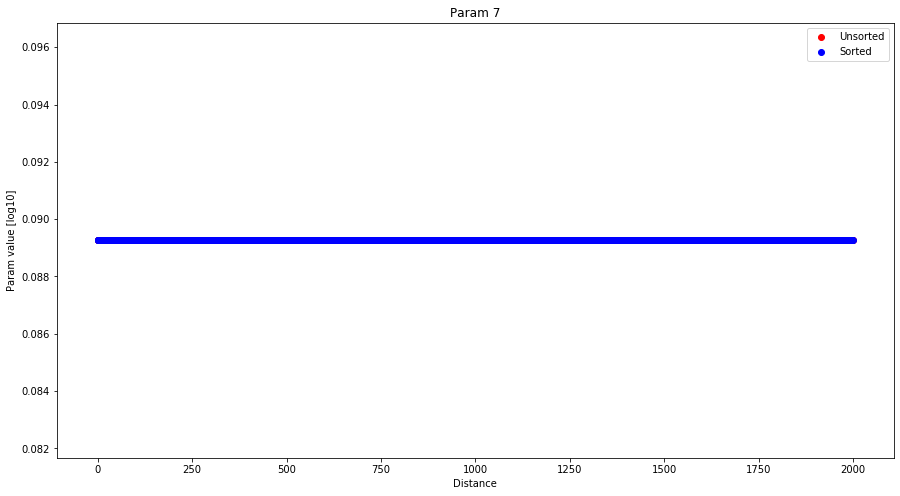

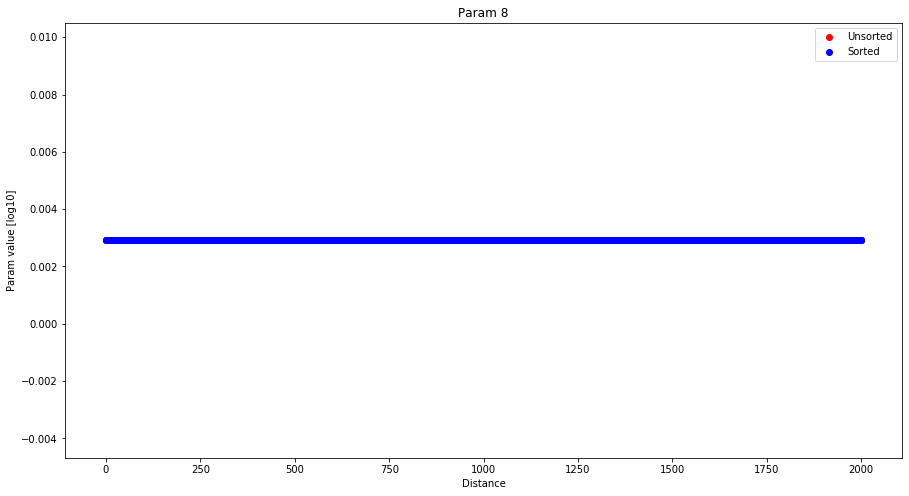

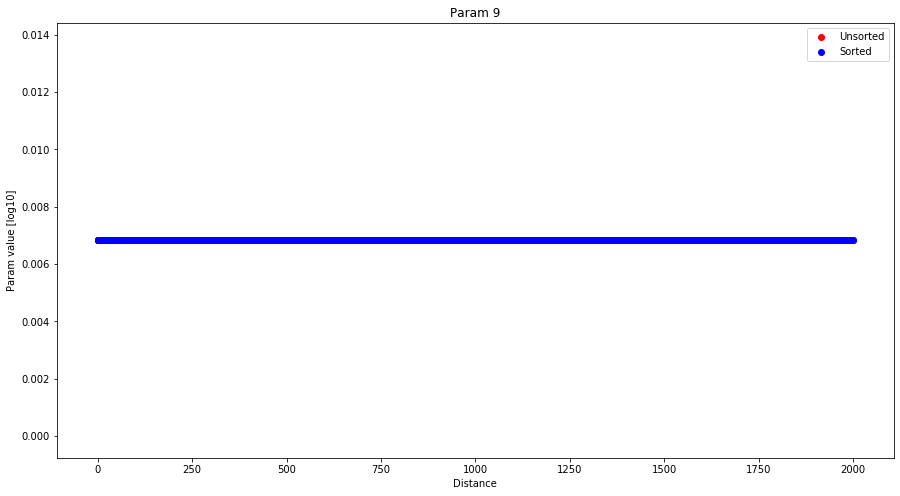

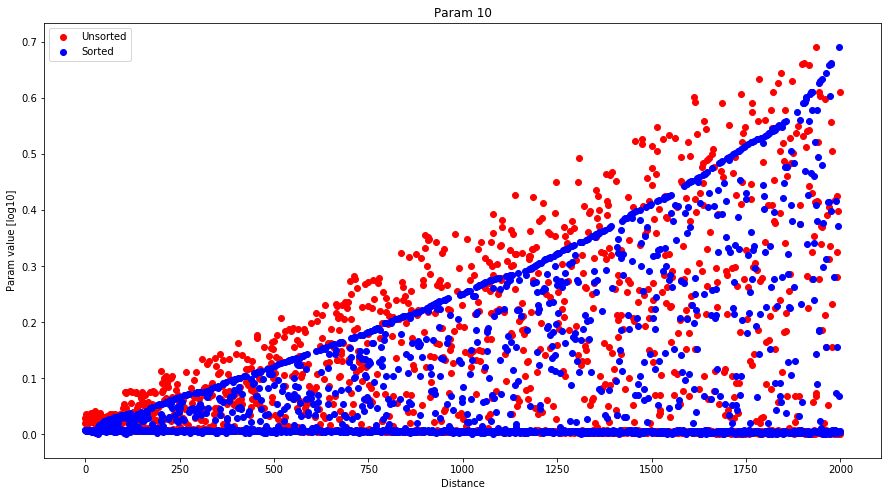

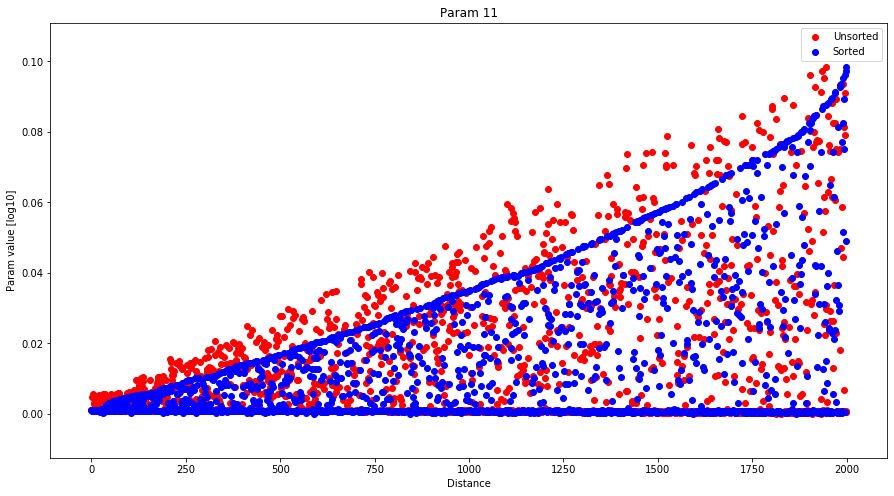

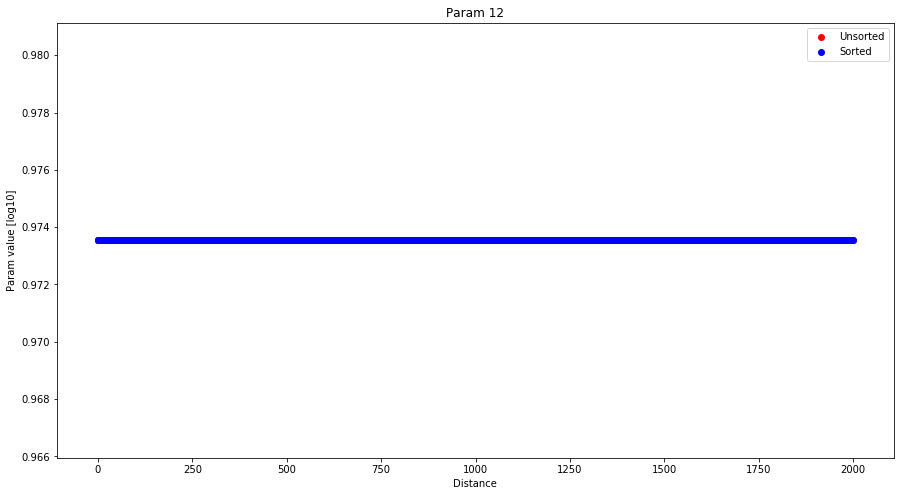

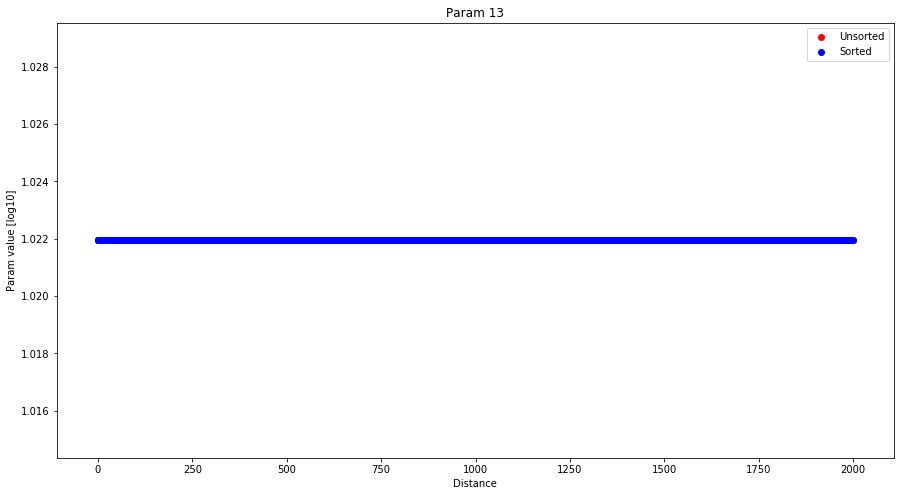

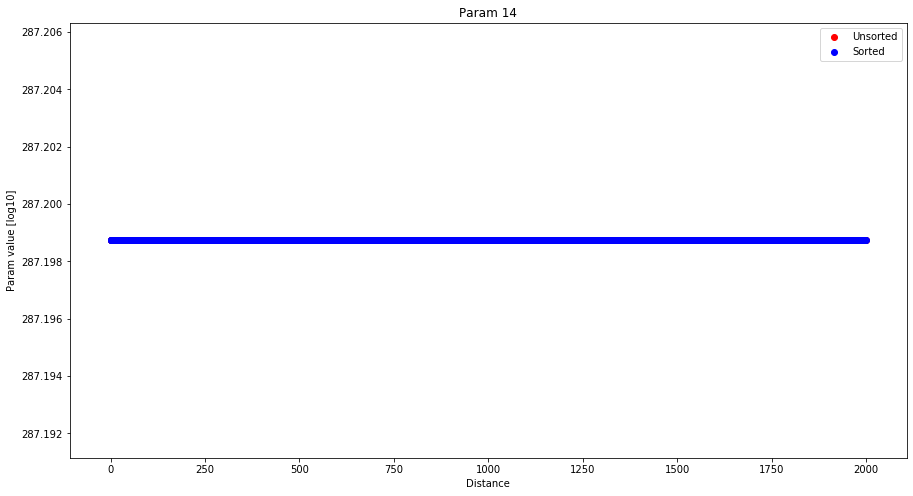

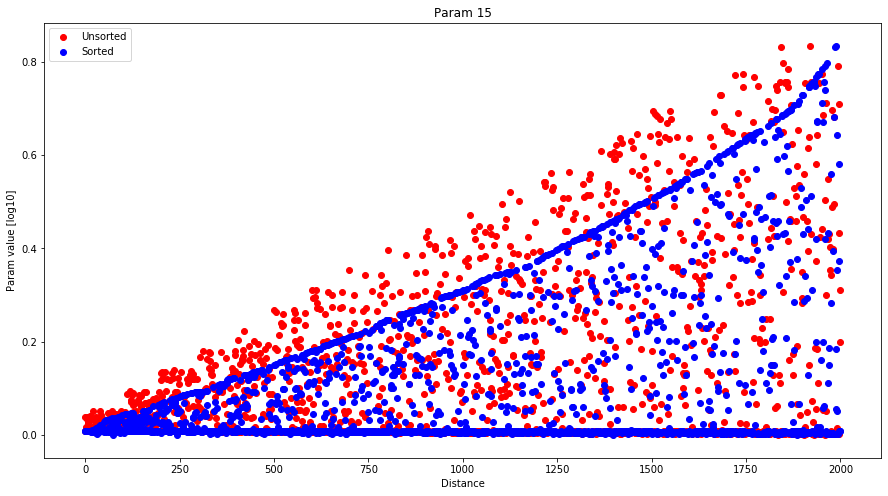

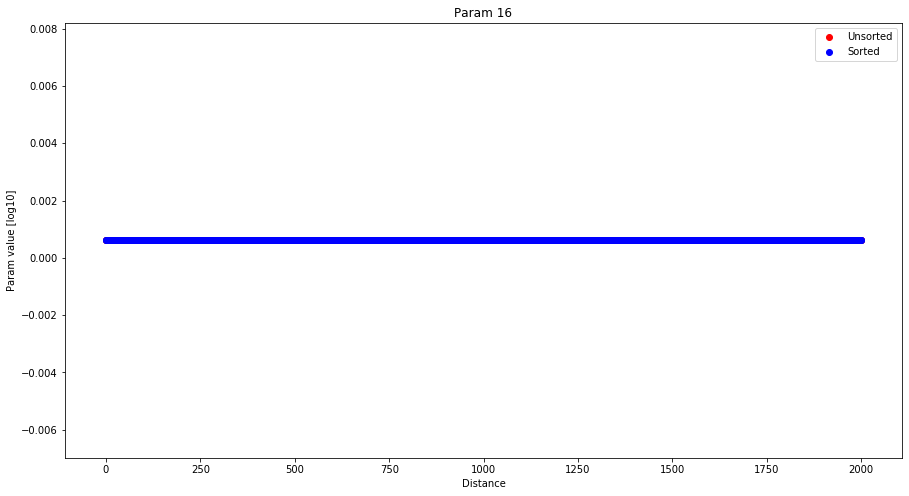

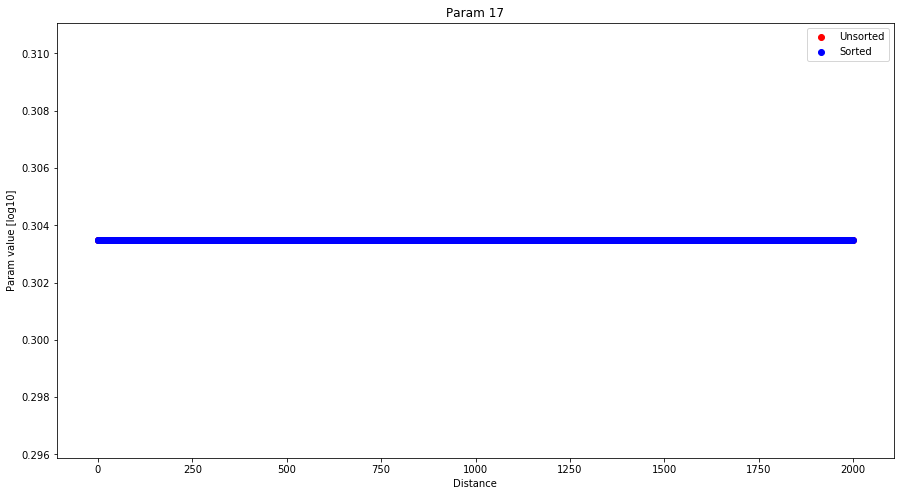

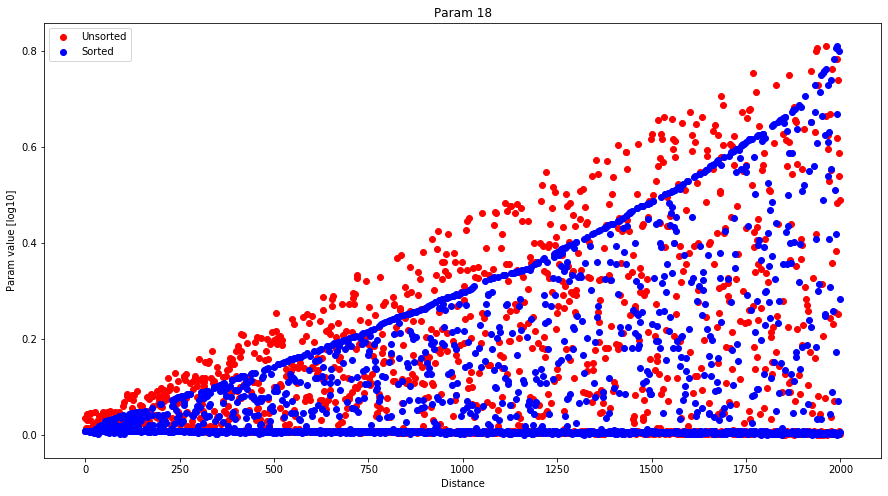

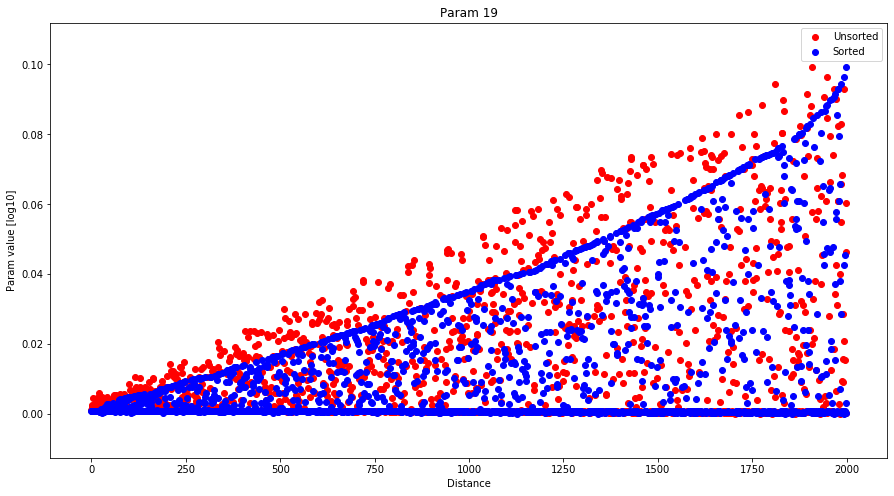

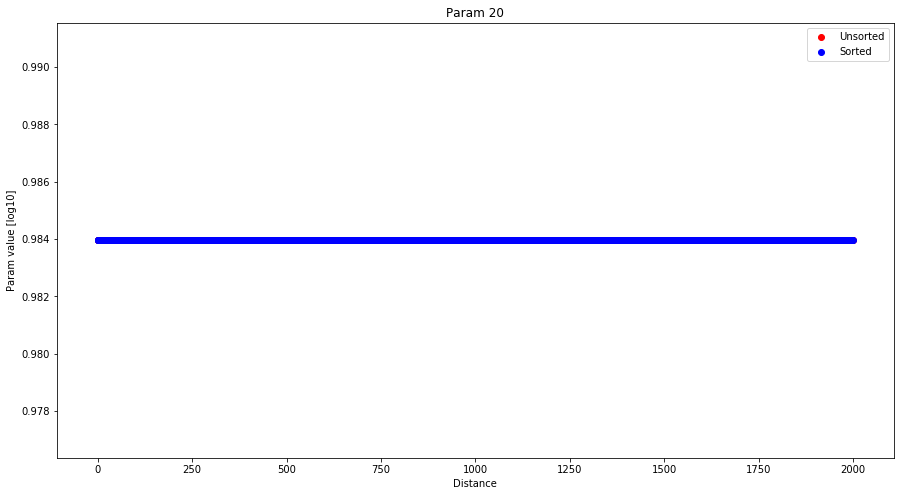

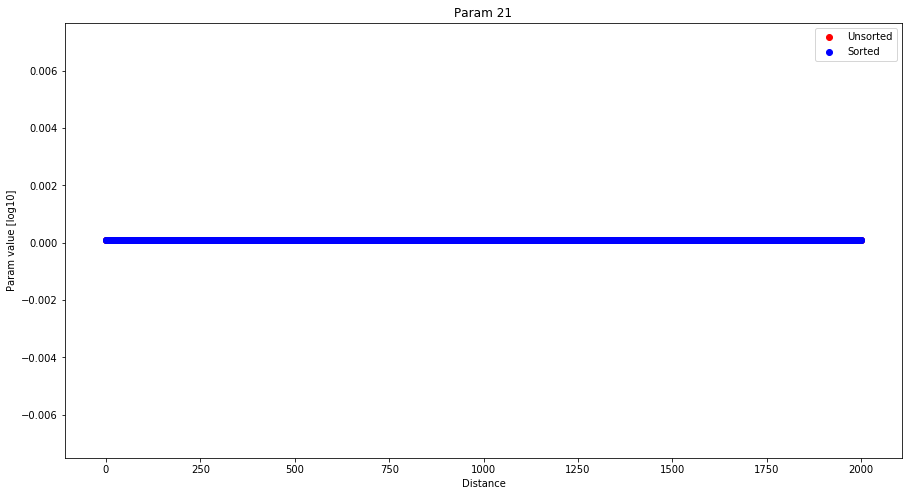

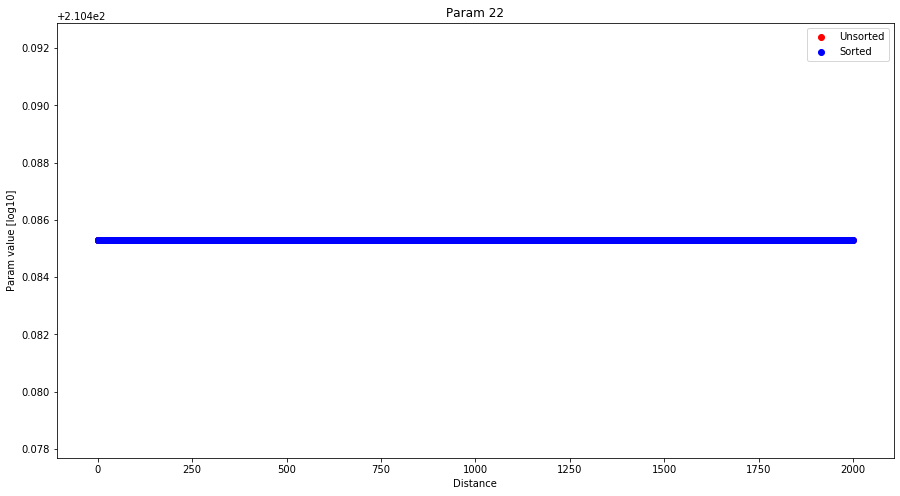

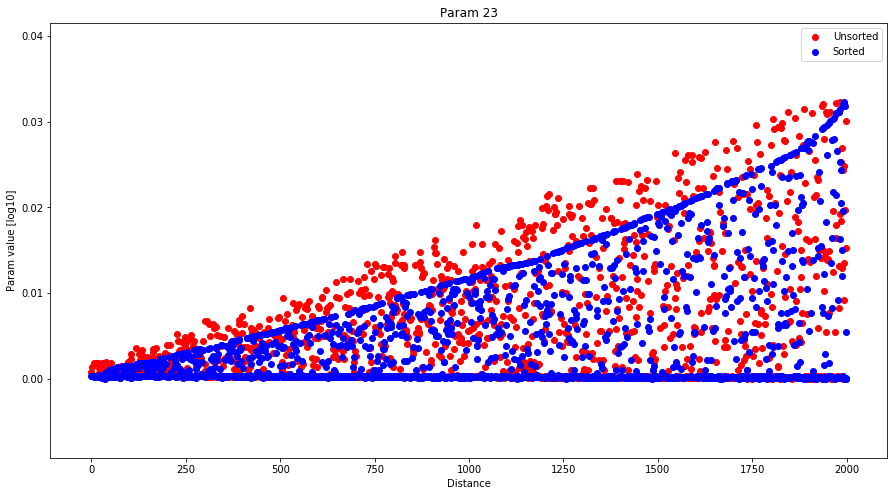

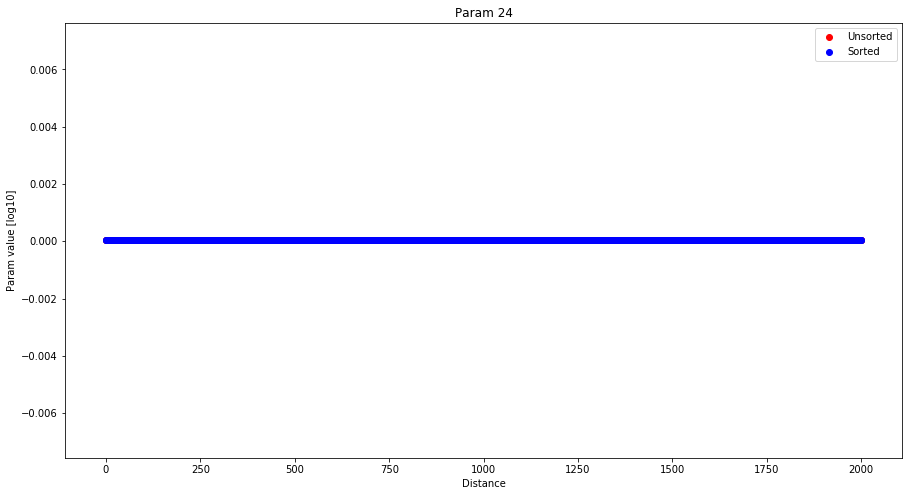

[[8.00000000e-05 2.61450000e-02 4.22600000e-03 8.00000000e-05
  1.43000000e-04 3.13796800e+00 8.92590000e-02 2.91000000e-03
  6.82700000e-03 6.86165156e-03 9.58980971e-04 9.73538000e-01
  1.02194500e+00 2.87198731e+02 8.71473874e-03 6.09000000e-04
  3.03472000e-01 8.38002522e-03 9.59693544e-04 9.83955000e-01
  8.00000000e-05 2.10485284e+02 3.23210246e-04 3.00000000e-05]
 [8.00000000e-05 2.61450000e-02 4.22600000e-03 8.00000000e-05
  1.43000000e-04 3.13796800e+00 8.92590000e-02 2.91000000e-03
  6.82700000e-03 6.92110933e-03 9.74378016e-04 9.73538000e-01
  1.02194500e+00 2.87198731e+02 8.61192689e-03 6.09000000e-04
  3.03472000e-01 8.23997618e-03 9.65597483e-04 9.83955000e-01
  8.00000000e-05 2.10485284e+02 3.20850829e-04 3.00000000e-05]
 [8.00000000e-05 2.61450000e-02 4.22600000e-03 8.00000000e-05
  1.43000000e-04 3.13796800e+00 8.92590000e-02 2.91000000e-03
  6.82700000e-03 7.06883583e-03 9.49164574e-04 9.73538000e-01
  1.02194500e+00 2.87198731e+02 8.56053216e-03 6.09000000e-04
  3.03

In [3]:
# data is the parsed csv, orig is a row vector of base values for each param (1 x 12)
data, orig = helper.parse_csv(file_path)  
pMatx, pSortedMatx, pSetsN, pSortedSetsN = helper.calculate_pmatx(data, nSubZones, nPerSubZone, params, norm, seed) 

'''
pMatx is the final pin data after sampling in a range of [-4, 4] and applying the uniform function. Each param not in the params list will be kept at 0 and not sampled.
pSortedMatx is calculated by sorting by the summed squared differences from the original param value after sampling in the range [-4, 4] and then applying the uniform function. This matrix was mainly used for plotting the sorted values vs unsorted values to look at the general relationship between the two.
pSetsN is the samples from [-4, 4] for each param.
pSortedSetsN is the sorted squared differences from the original param value after sampling in the range [-4, 4]. This does not have the uniform function applied, because we use this matrix for the OAT analysis. 

'''
# Save matrices as hdf5 files.
parmas_nwb = h5py.File('../run_volts_bbp_'+peeling_step_name+'/params/params_bbp_'+peeling_step_name+'.hdf5', 'w')
parmas_nwb.create_dataset('orig_'+peeling_step_name, data=orig)
parmas_nwb.create_dataset('pin_'+str(len(pSortedMatx))+'_'+peeling_step_name, data=pSortedMatx)
# np.savetxt('./test_pin.csv', pSortedMatx) # Debug

dx_matrix = helper.shift_by_dx(pSortedSetsN, dx, params)
final_p = helper.calculate_pmatx_dx(data, dx_matrix)
param_num = len(params)
sampled_dx_matrix = []
for i in pin_sample_ind:
    for j in range(param_num):
        sampled_dx_matrix.append(final_p[i*param_num+j])
parmas_nwb.create_dataset('pdx_'+str(len(sampled_dx_matrix))+'_'+str(dx)+'_'+peeling_step_name, data=np.array(sampled_dx_matrix))
parmas_nwb.create_dataset('sample_ind', data=np.array(pin_sample_ind))
parmas_nwb.create_dataset('param_num', data=np.array([param_num]))
parmas_nwb.create_dataset('dx', data=np.array([dx]))
# np.savetxt('./test_pdx.csv', sampled_dx_matrix) #Debug
parmas_nwb.close()
# Plots final pMatx against pSortedMatx
helper.plot_sorted(pMatx, pSortedMatx)
print(pSortedMatx)